# Assignment 3, Joshua Lympany 5771204

# I. modernity
## 1. Folder Preparation (as subfolders are annoying to deal with)

In [72]:
import os
import pandas as pd
import shutil
import numpy as np
import torch
from torchvision import transforms
import time
import warnings
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import ParameterGrid
from random import sample
import torch.nn.functional as F
import matplotlib.patches as patches

warnings.filterwarnings("ignore")
device = torch.device("cuda")
device

device(type='cuda')

### Don't run again
#### This writes all the files into one folder, instead of having multiple

In [ ]:
def bring_forward(source, target):
    counter = 1
    print('go')
    for root, _, files in os.walk(source):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg')):
                src_file = os.path.join(root, file)
                
                target_file = os.path.join(target, file)
                while os.path.exists(target_file):
                    name, ext = os.path.splitext(file)
                    target_file = os.path.join(target, f"{name}_{counter}{ext}")
                    counter += 1
                shutil.copy2(src_file, target_file)

s = 'confirmed_fronts2/'  
t = 'fronts_nice/'  
if not os.path.exists(t):
    os.makedirs(t)
bring_forward(s, t)

### make sure it worked

In [73]:
def count(path):
    tot = 0
    for root, dirs, files in os.walk(path):
        tot += len(files)
    return tot

folder_old= 'extracted_files/confirmed_fronts2/' 
folder_new = 'fronts_nice/'  
old = count(folder_old)
new = count(folder_new)
print(f'Old files: {old}')
print(f'New files: {new}')
print(f'It seems we lost: {old-new} files, probably because not jpg or jpeg format')

Old files: 61831
New files: 61827
It seems we lost: 4 files, probably because not jpg or jpeg format


### nice dataframe, so that i can group accordingly

In [32]:
small = False

### GET THE FILE NAMES
file_names = []
for root, dirs, files in os.walk(folder_new):
    for file_name in files:
        file_names.append(file_name)
names = pd.DataFrame(file_names, columns=['File_Name'])

### MAKE THEM NICE
data2 = names.copy()
data2[['Brand_Name', 'Model_Name', 'Launch_Year', 'Color', 'Model_ID', 'Advertiser_ID', 'Image_ID']] = data2['File_Name'].str.split('[$][$]', expand=True)
data2['Launch_Year'] = data2['Launch_Year'].astype(int)

data2['grouped_year'] = 0
data2.loc[data2['Launch_Year'].isin([2000, 2003]), 'grouped_year'] = 0
data2.loc[data2['Launch_Year'].isin([2006, 2007, 2008, 2009, 2010]), 'grouped_year'] = 1
data2.loc[data2['Launch_Year'].isin([2011, 2012, 2013, 2014]), 'grouped_year'] = 2
data2.loc[data2['Launch_Year'].isin([2015, 2016, 2017, 2018]), 'grouped_year'] = 3

### MERGE THEM WITH THE bodytype (for later)
autos = pd.read_csv('autos.csv')
autos2 = autos.copy()
autos2.rename(columns={'model_year': 'Launch_Year', 'model_id': 'Model_ID'}, inplace=True)
autos_merg = pd.merge(data2, autos2, on=['Launch_Year', 'Model_ID'], how='inner')

data = autos_merg.dropna()
data2 = autos_merg.dropna()

if small:  # this is just for testing, up top small is set to False for the main project / run through
    n = 4000
    data = autos_merg.sample(n=n, random_state=1).dropna()

data.head(1)

,File_Name,Brand_Name,Model_Name,Launch_Year,Color,Model_ID,Advertiser_ID,Image_ID,grouped_year,bodytype
0,Audi$$S3$$2009$$Red$$7_35$$278$$image_11.jpg,Audi,S3,2009,Red,7_35,278,image_11.jpg,1,Hatchback


## 2. train / test / val
### train test split, but according to the rules stated (no splitting of model_id or year)

In [76]:
groups = data.groupby(['Model_ID', 'Launch_Year'])

train_df = pd.DataFrame(columns=data.columns)
test_df = pd.DataFrame(columns=data.columns)
val_df = pd.DataFrame(columns=data.columns)

for name, data_g in groups:
    if len(data_g) < 3: # can't to train test val split on less than 3 items
        train_df = pd.concat([train_df, data_g])
    else:
        train_data, test_val_data = train_test_split(data_g, test_size=0.3, random_state=42) # split into train and testBIG
        if len(test_val_data) < 2:
            train_data = pd.concat([train_data, test_val_data])
        else:
            test_data, val_data = train_test_split(test_val_data, test_size=0.33, random_state=42) # split testBIG into test and val
            test_df = pd.concat([test_df, test_data])
            val_df = pd.concat([val_df, val_data])
        
        train_df = pd.concat([train_df, train_data])

print('Training: ',len(train_df)/len(data))
print('Test: ', len(test_df)/len(data))
print('Validation: ', len(val_df)/len(data))
print('Length of summed up dfs: ', len(train_df) + len(test_df) + len(val_df), '. Compared to original: ', len(data))

Training:  0.6977147487844408
Test:  0.19288492706645058
Validation:  0.1094003241491086
Length of summed up dfs:  61700 . Compared to original:  61700


### calculate the mean and standard deviation of the train set, in order to normalize later on

In [291]:
def mean_std(dir, df):
    num = len(df)
    mean = torch.zeros(3)
    std = torch.zeros(3)

    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    
    for idx, row in df.iterrows():
        name = row['File_Name']
        path = os.path.join(dir, name)
        image = Image.open(path).convert("RGB")
        image = transform(image)
        mean += torch.mean(image, dim=(1, 2))
        std += torch.std(image, dim=(1, 2))
   
    mean /= num
    std /= num
    return mean, std

dir = 'fronts_nice'
mean, std = mean_std(dir, train_df)

print(f'Computed mean: {mean}')
print(f'Computed std: {std}')
normalizer = transforms.Normalize(mean=mean, std=std)

Computed mean: tensor([0.6670, 0.6665, 0.6817])
Computed std: tensor([0.3498, 0.3488, 0.3401])


In [87]:
unique_labels = data2['Launch_Year'].unique()
print(f'{len(unique_labels)} Labels : {unique_labels}')

15 Labels : [2009 2010 2006 2007 2017 2016 2015 2011 2012 2014 2013 2008 2018 2003
 2000]


## My transformer
#### I do this beforehand so that I use less computational power when training the model. it does take quite long as well but after trying both ways this seems to be faster. (rather than transforming every time)

In [7]:
# function takes a dataframe and searches for all the image files inside of it. it also one hot encodes the target variable
def transformer(dir, df, train, enc, var):
    transformed_images = []
    encoded_labels = []

    count = 0
    mean = torch.tensor([0.6670, 0.6665, 0.6817])
    std = torch.tensor([0.3498, 0.3488, 0.3401])
    normalizer = transforms.Compose([transforms.Normalize(mean=mean, std=std)])

    # we only want resized crop if in training
    transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mean, std=std)])
        
    if train == 0:
        transform = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std)])
        
    for idx, row in df.iterrows():
        # here the images are transformed
        name = row['File_Name']
        path = os.path.join(dir, name)
        image = Image.open(path).convert("RGB")
        image = transform(image)
        transformed_images.append(image)
        
        # here the target is one hot encoded
        year = row[var]
        label = torch.tensor(enc.transform(np.array([[year]])).toarray())
        encoded_labels.append(label)

        # slow down a bit
        count = count + 1
        if count == 5000:
            print(5000)
            time.sleep(5)
            count = 0
    
    combined_tensors = {
    'images': torch.stack(transformed_images),
    'labels': torch.stack(encoded_labels).squeeze(1)
}
    return combined_tensors # returns the combined tensors with input / output

var = 'Launch_Year'
encoder = OneHotEncoder()
encoder.fit(data[[var]])

st = time.time()

dir = 'fronts_nice'
train = transformer(dir, train_df, 1, encoder, var)
test = transformer(dir, test_df, 0, encoder, var)
val = transformer(dir, val_df, 0, encoder, var)

en = time.time()
ex = en - st
print(f'Execution Time: {round(ex/60, 3)} minutes')

5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
Execution Time: 17.82 minutes


## Functions for loading the dataset later on

In [77]:
class dataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label
    
train_set = dataset(train['images'], train['labels'])
test_set = dataset(test['images'], test['labels'])
val_set = dataset(val['images'], val['labels'])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=0)

## 3. Model

In [79]:
device = torch.device("cuda")
model = models.resnet18(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False # freeze
for param in model.fc.parameters():
    param.requires_grad = True

classes = len(data2['Launch_Year'].unique())
model.fc = torch.nn.Linear(model.fc.in_features, classes)

## Training function

In [80]:
def trainer(model, data_loader, loss_fn, optimizer, scheduler, train, best_loss, not_better, patience=2):
    device = torch.device("cuda")
    model.to(device)

    # check if train/validation
    model.train(True)
    if train==0:
          model.eval()

    # the actual training
    r_loss = 0.0
    r_corr = 0.0
    tot = 0

    for data in data_loader:
            inputs, labels = data 
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            labs = torch.argmax(labels, dim=1)
            correct = (preds == labs).sum().item()

            r_corr += correct 
            r_loss += loss.item()
            tot += len(data[0])

    epoch_loss = r_loss / tot
    epoch_acc = r_corr / tot
    
    # scheduling
    if scheduler is not None: 
        scheduler.step()

    # early stopping
    if epoch_loss < best_loss: 
        best_loss = epoch_loss
        not_better = 0
    else:
        not_better += 1
        
    if not_better >= patience:
        return epoch_loss, epoch_acc, best_loss, not_better, False

    return epoch_loss, epoch_acc, best_loss, not_better, True


## Hyperparameter tuning

In [79]:
param_grid = {'lr': [0.001, 0.01], 'step': [1, 2], 'gamma': [0.1, 0.5], 'patience': [2, 3]} # these can obviously be adjusted, however it should do
BEST_PARAMS, VAL_LOSS = None, float('inf')

st = time.time()

# here i run various inputs on a grid and save the parameters which produce the lowest validation loss
for params in ParameterGrid(param_grid):
    print(f'Testing combination: {params}')

   # model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    loss_fn = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=params['step'], gamma=params['gamma'])
    best_loss, not_better = float('inf'), 0

    for epoch in range(10):
        ep_loss, ep_acc, best_loss, not_better, check = trainer(model, train_loader, loss_fn, optimizer, scheduler, 1, best_loss, not_better, patience=params['patience'])  
        if not check:
            break
            
    ep_loss, ep_acc, best_loss, not_better, check = trainer(model, val_loader, loss_fn, optimizer, scheduler, 0, best_loss, not_better)
    if ep_loss < VAL_LOSS:
        VAL_LOSS = best_loss
        BEST_PARAMS = params

en = time.time()
ex = en - st
print(f'Best parameters: {BEST_PARAMS} | validation loss: {VAL_LOSS:.4f}')
print(f'Execution Time: {round(ex/60, 3)} minutes')


Testing combination: {'gamma': 0.1, 'lr': 0.001, 'patience': 2, 'step': 1}
Testing combination: {'gamma': 0.1, 'lr': 0.001, 'patience': 2, 'step': 2}
Testing combination: {'gamma': 0.1, 'lr': 0.001, 'patience': 3, 'step': 1}
Testing combination: {'gamma': 0.1, 'lr': 0.001, 'patience': 3, 'step': 2}
Testing combination: {'gamma': 0.1, 'lr': 0.01, 'patience': 2, 'step': 1}
Testing combination: {'gamma': 0.1, 'lr': 0.01, 'patience': 2, 'step': 2}
Testing combination: {'gamma': 0.1, 'lr': 0.01, 'patience': 3, 'step': 1}
Testing combination: {'gamma': 0.1, 'lr': 0.01, 'patience': 3, 'step': 2}
Testing combination: {'gamma': 0.5, 'lr': 0.001, 'patience': 2, 'step': 1}
Testing combination: {'gamma': 0.5, 'lr': 0.001, 'patience': 2, 'step': 2}
Testing combination: {'gamma': 0.5, 'lr': 0.001, 'patience': 3, 'step': 1}
Testing combination: {'gamma': 0.5, 'lr': 0.001, 'patience': 3, 'step': 2}
Testing combination: {'gamma': 0.5, 'lr': 0.01, 'patience': 2, 'step': 1}
Testing combination: {'gamma':

## Training with the best hyperparameters

In [81]:
# BEST_PARAMS = {'gamma': 0.1, 'lr': 0.001, 'patience': 2, 'step': 2}
epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=BEST_PARAMS['lr'])
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=BEST_PARAMS['step'], gamma=BEST_PARAMS['gamma'])
best_loss, not_better, bot_b = float('inf'), 0, 0

for epoch in range(epochs):
    ep_loss, ep_acc, best_loss, not_better, check = trainer(model, train_loader, loss_fn, optimizer, scheduler, 1, best_loss, not_better, BEST_PARAMS['patience'])
    ep_loss_v, ep_acc_v, best_loss_v, not_better_v, check_v = trainer(model, val_loader, loss_fn, optimizer, scheduler, 0, best_loss, not_better, BEST_PARAMS['patience'])

    if not check: 
        print(f'Stopped early at epoch {epoch} due to no improvement.')
        break
    print(f'Epoch {epoch + 1}: Loss: {ep_loss_v:.4f} Acc: {ep_acc_v:.4f}')

Epoch 1: Loss: 0.0357 Acc: 0.2041
Epoch 2: Loss: 0.0327 Acc: 0.2367
Epoch 3: Loss: 0.0326 Acc: 0.2399
Epoch 4: Loss: 0.0327 Acc: 0.2403
Epoch 5: Loss: 0.0327 Acc: 0.2390
Epoch 6: Loss: 0.0326 Acc: 0.2413
Epoch 7: Loss: 0.0326 Acc: 0.2375
Epoch 8: Loss: 0.0327 Acc: 0.2390
Epoch 9: Loss: 0.0326 Acc: 0.2416
Epoch 10: Loss: 0.0327 Acc: 0.2416
Stopped early at epoch 10 due to no improvement.


## 4. Testing

Accuracy of test set : 23.70%


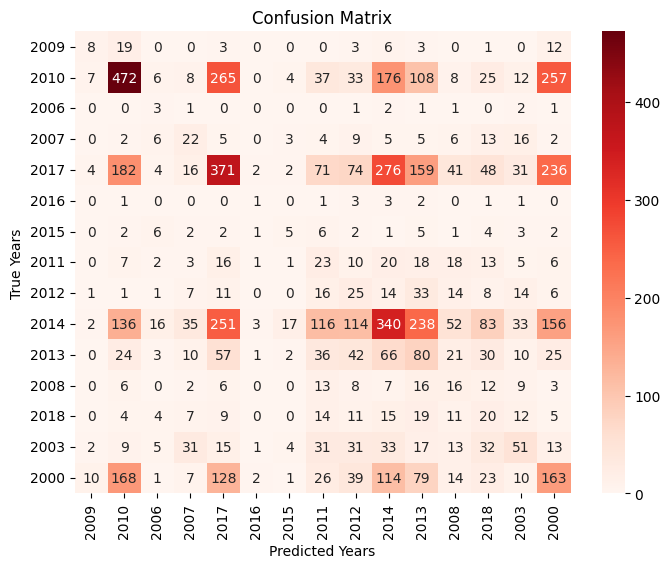

In [110]:
def tester(model, data_loader, loss_fn, optimizer):
    device = torch.device("cuda")
    model.to(device)
    model.eval()

    predictions = []
    actuals = []
    
    # the actual testing
    r_loss = 0.0
    r_corr = 0.0
    tot = 0

    for data in data_loader:
            inputs, labels = data 
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            labs = torch.argmax(labels, dim=1)
            correct = (preds == labs).sum().item()

            r_corr += correct 
            r_loss += loss.item()
            tot += len(data[0])
        
            predictions.append(preds)
            actuals.append(labs)
        
    predictions = torch.cat(predictions)
    actuals = torch.cat(actuals)

    orig = list(unique_labels)
    
    predictions = [orig[i] for i in predictions]
    actuals = [orig[i] for i in actuals]

    epoch_loss = r_loss / tot
    epoch_acc = r_corr / tot
    
    return epoch_loss, epoch_acc, predictions, actuals

epoch_loss, ultimate_accuracy, predictions, actuals = tester(model, val_loader, loss_fn, optimizer)

print(f'Accuracy of test set : {100*ultimate_accuracy:.2f}%')

conf = confusion_matrix(predictions, actuals)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt="d", cmap="Reds", xticklabels=list(unique_labels), yticklabels=list(unique_labels))
plt.xlabel('Predicted Years')
plt.ylabel('True Years')
plt.title('Confusion Matrix')
plt.show()

In [82]:
ultimate_loss, ultimate_accuracy, ubl, nb, ch = trainer(model, test_loader, loss_fn, optimizer, scheduler, 0, best_loss, not_better, BEST_PARAMS['patience'])
print(f'Accuracy of test set : {100*ultimate_accuracy:.2f}%')


Accuracy of test set : 23.75%


## 5. 20 images with their respective scores

In [83]:
# change train_df to test_df

test_df_20 = pd.DataFrame()

# sample 4 cars for each of the given years
for year in [2000, 2006, 2010, 2014, 2017]:
    sampled_data = test_df[test_df['Launch_Year'] == year].sample(4)
    test_df_20 = pd.concat([test_df_20, sampled_data], ignore_index=True)

test_20 = transformer(dir, test_df_20, 0, encoder, var)
test_20_set = dataset(test_20['images'], test_20['labels'])
test_20_loader = DataLoader(test_20_set, batch_size=64, shuffle=False, num_workers=0)

## My modernity score will be a float between 0 and 10
#### 10 being the most modern. 
#### My classifications where simply the Launch Years (15 in total)
#### This means I can softmax the predictions
#### Then use these weights for the actual classes (the years)
#### Then calculate a weighted predicted year
#### The normalize that between 1 and 10

In [84]:
def get_modernity(ten, true):
    weights = torch.softmax(ten, dim=0).to(device)
    if true: 
        weights = ten.to(device)
    class_labels = sorted(set(encoder.inverse_transform(np.unique(train['labels'].detach().numpy(), axis=0)).flatten()))
    year_classes = torch.tensor(class_labels).to(device)
    pred = torch.sum(weights*year_classes).item()
    norm = (pred - 2000) / (2018 - 2000) * 10
    return norm

In [85]:
modernity_true_values = []
modernity_predictions = []

device = torch.device("cuda")

model.to(device)
for data in test_20_loader:
    inp, out = data
    inp, out = inp.to(device), out.to(device)
    out_pred = model(inp).to(device)
    for i in range(out_pred.shape[0]):
        mod_true = get_modernity(test_20['labels'][i], True)
        mod_pred = get_modernity(out_pred[i], False)
       
        modernity_true_values.append(mod_true)
        modernity_predictions.append(mod_pred)

modernity_true_values
test_df_20['modernity'] = modernity_true_values

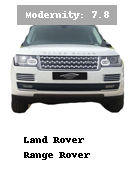

In [86]:
font = ImageFont.load_default()
image_paths = test_df_20['File_Name'].to_numpy()
brand_name = test_df_20['Brand_Name'].to_numpy()
model_name = test_df_20['Model_Name'].to_numpy()
modernity = test_df_20['modernity'].to_numpy()
colors = test_df_20['Color'].to_numpy()

def get_image(path, brand, model, mod, color): # creates and resizes an image, an writes true/predicted 
 im = Image.open('fronts_nice/'+ path)
 b = im.resize((124, 124)) 
 w, h = b.width, b.height
 white = Image.new("RGB", (w+10, h+50), color="white")
 white.paste(b, (5, 5))
 back = "darkgrey"
 if color == 'Silver' or color== 'Grey':
     back = 'black'
 grey = Image.new("RGB", (100, 20), color=back)
 white.paste(grey, (17, 5))
 draw = ImageDraw.Draw(white)
 t1, t2, t3 = w/2-36, w/2-38, w/2+5
 draw.text((t2, h+10), brand, fill="black", font=font, anchor='ms')
 draw.text((t2, h+25), model, fill="black", font=font, anchor='ms')
 try: draw.text((t1, 9), 'Modernity: '+ str(round(mod, 1)), fill=color, font=font, anchor='l')
 except Exception as e:
        draw.text((t1, 9), 'Modernity: '+ str(round(mod, 1)), fill='black', font=font, anchor='ms')
 return white

d = 12
get_image(image_paths[d], brand_name[d], model_name[d], modernity[d], colors[d])


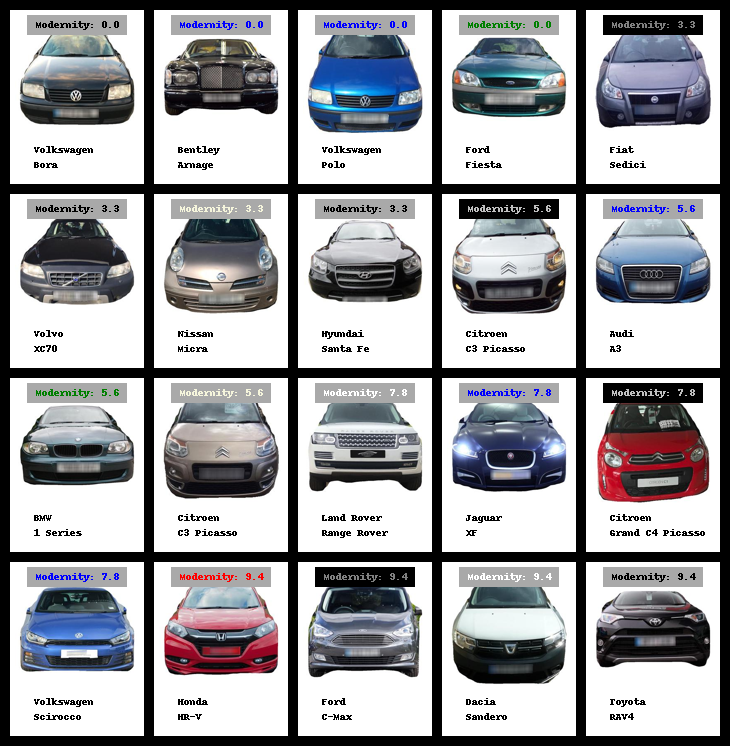

In [87]:
def connect_images(df):
    # Get arrays
    image_paths = test_df_20['File_Name'].to_numpy()
    brand_name = test_df_20['Brand_Name'].to_numpy()
    model_name = test_df_20['Model_Name'].to_numpy()
    modernity = test_df_20['modernity'].to_numpy()
    colors = test_df_20['Color'].to_numpy()
    
    # Prepare main canvas
    d=2
    im = get_image(image_paths[d], brand_name[d], model_name[d], modernity[d], colors[d])
    w, h = im.width, im.height
    entire = Image.new("RGB", ((w + 10) * 5 + 10, (h + 10) * 4 + 10), color="black")
    f = 10
    r = 10
    placed = 0

    # Add the selected images
    for i in range(20):
        im = get_image(image_paths[i], brand_name[i], model_name[i], modernity[i], colors[i])
        entire.paste(im, (f, r))
        f += w + 10
        placed += 1
        if placed % 5 == 0:
            f = 10
            r += h + 10
    return entire

connect_images(test_df_20)


# II. BODYTYPE

## 1. preprocessing
#### I recreate the transformer function, however only to one hot encode the targets again. it would be a waste of time and ressources to do the images again

In [12]:
# function takes a dataframe and one hot encodes the target variable. 
# also takes the previous image features so that i dont have to do that again.
def transformer2(df, enc, var, image_features):
    encoded_labels = []
    count = 0
 
    for idx, row in df.iterrows():
        # here the target is one hot encoded
        year = row[var]
        label = torch.tensor(enc.transform(np.array([[year]])).toarray())
        encoded_labels.append(label)

    combined_tensors = {
    'images': image_features,
    'labels': torch.stack(encoded_labels).squeeze(1)
}
    return combined_tensors # returns the combined tensors with input / output


In [13]:
var = 'bodytype'
encoder = OneHotEncoder()
encoder.fit(data2[[var]])

st = time.time()

train2 = transformer2(train_df, encoder, var, train['images']) 
test2 = transformer2(test_df, encoder, var,  test['images'])
val2 = transformer2(val_df, encoder, var,  val['images'])

en = time.time()
ex = en - st
print(f'Execution Time: {round(ex/60, 3)} minutes')

Execution Time: 0.414 minutes


In [14]:
train_set2 = dataset(train2['images'], train2['labels'])
test_set2 = dataset(test2['images'], test2['labels'])
val_set2 = dataset(val2['images'], val2['labels'])

train_loader2 = DataLoader(train_set2, batch_size=64, shuffle=True, num_workers=0)
test_loader2 = DataLoader(test_set2, batch_size=64, shuffle=True, num_workers=0)
val_loader2 = DataLoader(val_set2, batch_size=64, shuffle=True, num_workers=0)

## Model

In [15]:
device = torch.device("cuda")

model2 = models.resnet18(pretrained=True).to(device)
for param in model2.parameters():
    param.requires_grad = False
for param in model2.fc.parameters():
    param.requires_grad = True

types = len(data2['bodytype'].unique())
model2.fc = torch.nn.Linear(model2.fc.in_features, types)

## Hyperparameter tuning

In [92]:
from sklearn.model_selection import ParameterGrid

param_grid = {'lr': [0.001, 0.01], 'step': [1, 2], 'gamma': [0.1, 0.5], 'patience': [3, 5]}
BEST_PARAMS, VAL_LOSS = None, float('inf')

for params in ParameterGrid(param_grid):
    print(f'Testing combination: {params}')

   # model.to(device)
    optimizer = torch.optim.Adam(model2.parameters(), lr=params['lr'])
    loss_fn = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=params['step'], gamma=params['gamma'])
    best_loss, not_better = float('inf'), 0

    for epoch in range(10):
        ep_loss, ep_acc, best_loss, not_better, check = trainer(model2, train_loader2, loss_fn, optimizer, scheduler, 1, best_loss, not_better, patience=params['patience'])  
        if not check:
            break
            
    ep_loss, ep_acc, best_loss, not_better, check = trainer(model2, val_loader2, loss_fn, optimizer, scheduler, 0, best_loss, not_better)
    if ep_loss < VAL_LOSS:
        VAL_LOSS = best_loss
        BEST_PARAMS = params

print(f'Best parameters: {BEST_PARAMS} | validation loss: {VAL_LOSS:.4f}')


Testing combination: {'gamma': 0.1, 'lr': 0.001, 'patience': 3, 'step': 1}
Testing combination: {'gamma': 0.1, 'lr': 0.001, 'patience': 3, 'step': 2}
Testing combination: {'gamma': 0.1, 'lr': 0.001, 'patience': 5, 'step': 1}
Testing combination: {'gamma': 0.1, 'lr': 0.001, 'patience': 5, 'step': 2}
Testing combination: {'gamma': 0.1, 'lr': 0.01, 'patience': 3, 'step': 1}
Testing combination: {'gamma': 0.1, 'lr': 0.01, 'patience': 3, 'step': 2}
Testing combination: {'gamma': 0.1, 'lr': 0.01, 'patience': 5, 'step': 1}
Testing combination: {'gamma': 0.1, 'lr': 0.01, 'patience': 5, 'step': 2}
Testing combination: {'gamma': 0.5, 'lr': 0.001, 'patience': 3, 'step': 1}
Testing combination: {'gamma': 0.5, 'lr': 0.001, 'patience': 3, 'step': 2}
Testing combination: {'gamma': 0.5, 'lr': 0.001, 'patience': 5, 'step': 1}
Testing combination: {'gamma': 0.5, 'lr': 0.001, 'patience': 5, 'step': 2}
Testing combination: {'gamma': 0.5, 'lr': 0.01, 'patience': 3, 'step': 1}
Testing combination: {'gamma':

# Training

In [18]:
BEST_PARAMS = {'gamma': 0.1, 'lr': 0.01, 'patience': 3, 'step': 1}
epochs = 20

optimizer = torch.optim.Adam(model2.parameters(), lr=BEST_PARAMS['lr'])
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=BEST_PARAMS['step'], gamma=BEST_PARAMS['gamma'])
best_loss, not_better, bot_b = float('inf'), 0, 0

for epoch in range(epochs):
    ep_loss, ep_acc, best_loss, not_better, check = trainer(model2, train_loader2, loss_fn, optimizer, scheduler, 1, best_loss, not_better, BEST_PARAMS['patience'])
    ep_loss_v, ep_acc_v, best_loss_v, not_better_v, check_v = trainer(model2, val_loader2, loss_fn, optimizer, scheduler, 0, best_loss, not_better, BEST_PARAMS['patience'])

    if not check: 
        print(f'Stopped early at epoch {epoch} due to no improvement.')
        break
    print(f'Epoch {epoch + 1}: Loss: {ep_loss_v:.4f} Acc: {ep_acc_v:.4f}')


Epoch 1: Loss: 0.0181 Acc: 0.5923
Epoch 2: Loss: 0.0172 Acc: 0.6157
Epoch 3: Loss: 0.0171 Acc: 0.6219
Epoch 4: Loss: 0.0171 Acc: 0.6221
Epoch 5: Loss: 0.0171 Acc: 0.6233
Epoch 6: Loss: 0.0171 Acc: 0.6213
Stopped early at epoch 6 due to no improvement.


## 2. This will be the new model with one less layer ($avgpool$)

In [19]:
model2_new = nn.Sequential(*list(model2.children())[:-1])

## 3. morph and 4. cosine
#### this function calculates the typicality score for a group

In [20]:
def get_typicality(data_loader):
    device = torch.device("cuda")
    model2_new.to(device)
    model2_new.train(True)
    morphs =  []

    for data in data_loader:
            inputs, labels = data 
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = model2_new(inputs)
            out_re = outputs.view(outputs.size(0), -1) # 64 x 512
            morphs.append(out_re)
 
    total = torch.cat(morphs, dim=0) # puts all into one tensor
    morphs = torch.mean(total, dim=0) # calculates the morph of each psoition
    cosine_similarities = F.cosine_similarity(morphs, total) # calculates the cosine similarity

    max_cos = torch.max(cosine_similarities).item() # maximum value
    max_ind = torch.argmax(cosine_similarities).item() # and its index
    
    min_cos = torch.min(cosine_similarities).item()  # minimum value
    min_ind = torch.argmin(cosine_similarities).item()  # and its index

    if (len(cosine_similarities)) > 5:
        cosnp = cosine_similarities.cpu().numpy()
        med_cos = np.median(cosnp)
        diff = np.abs(cosnp - med_cos)
        med_ind = diff.argmin()
    else:
        med_cos = 0 # median value
        med_ind = 0 # its index

    return max_cos, max_ind, min_cos, min_ind, med_cos, med_ind

In [63]:
# here i group together all of the dfs based on their year and type, output is a dictionary with all groups
groups = data.groupby(['grouped_year', 'bodytype'])
all_dfs = {}
for names, group in groups:
    name_tot = f'{names[0]}_{names[1]}'
    all_dfs[name_tot] = group.copy()

print('Total amount of seperate groups: ', len(all_dfs))

Total amount of seperate groups:  43


In [22]:
# function takes a dataframe and searches for all the image files inside of it. it also one hot encodes the target variable
def transformer3(dir, df, train, enc, var):
    transformed_images = []
    encoded_labels = []

    count = 0
    mean = torch.tensor([0.6675, 0.6671, 0.6820]) 
    std = torch.tensor([0.3496, 0.3488, 0.3403])
    normalizer = transforms.Compose([transforms.Normalize(mean=mean, std=std)])

    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mean, std=std)])
        
    if train == 0:
        transform = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std)])
        
    for idx, row in df.iterrows():
        # here the images are transformed
        name = row['File_Name']
        path = os.path.join(dir, name)
        image = Image.open(path).convert("RGB")
        image = transform(image)
        transformed_images.append(image)
        
        # here the target is one hot encoded
        year = row[var]
        label = torch.tensor(enc.transform(np.array([[year]])).toarray())
        encoded_labels.append(label)

        year = row[var]
        label = torch.tensor(enc.transform(np.array([[year]])).toarray())
        encoded_labels.append(label)

        # slow down a bit
        count = count + 1
        if count == 5000:
            print(5000)
            time.sleep(5)
            count = 0
    
    combined_tensors = {
    'images': torch.stack(transformed_images),
    'labels': torch.stack(encoded_labels).squeeze(1)
}
    return combined_tensors # returns the combined tensors with input / output

var = 'bodytype'
encoder = OneHotEncoder()
encoder.fit(data[[var]])
dir = 'fronts_nice'

## 5. highest cosine similarity

In [23]:
highest_df = pd.DataFrame()  
for key, df in all_dfs.items():
    transformed = transformer3(dir, df, 0, encoder, var) # transform
    transformed_set = dataset(transformed['images'], transformed['labels']) # dataset
    transformed_loader = DataLoader(transformed_set, batch_size=64, shuffle=False, num_workers=0) # dataloader
    max_cos, max_ind, min_cos, min_ind, med_cos, med_ind = get_typicality(transformed_loader) # get cosine / design typicality
    highest = df.iloc[max_ind] # GET HIGHEST
    highest_df = pd.concat([highest_df, highest.to_frame().T], ignore_index=True) # add to df

highest_df.to_csv('highest.csv', index=False)
highest_df.head(1)

5000
5000
5000
5000
5000


,File_Name,Brand_Name,Model_Name,Launch_Year,Color,Model_ID,Advertiser_ID,Image_ID,grouped_year,bodytype
0,Daihatsu$$Copen$$2003$$Silver$$24_3$$7$$image_...,Daihatsu,Copen,2003,Silver,24_3,7,image_1.jpg,0,Convertible


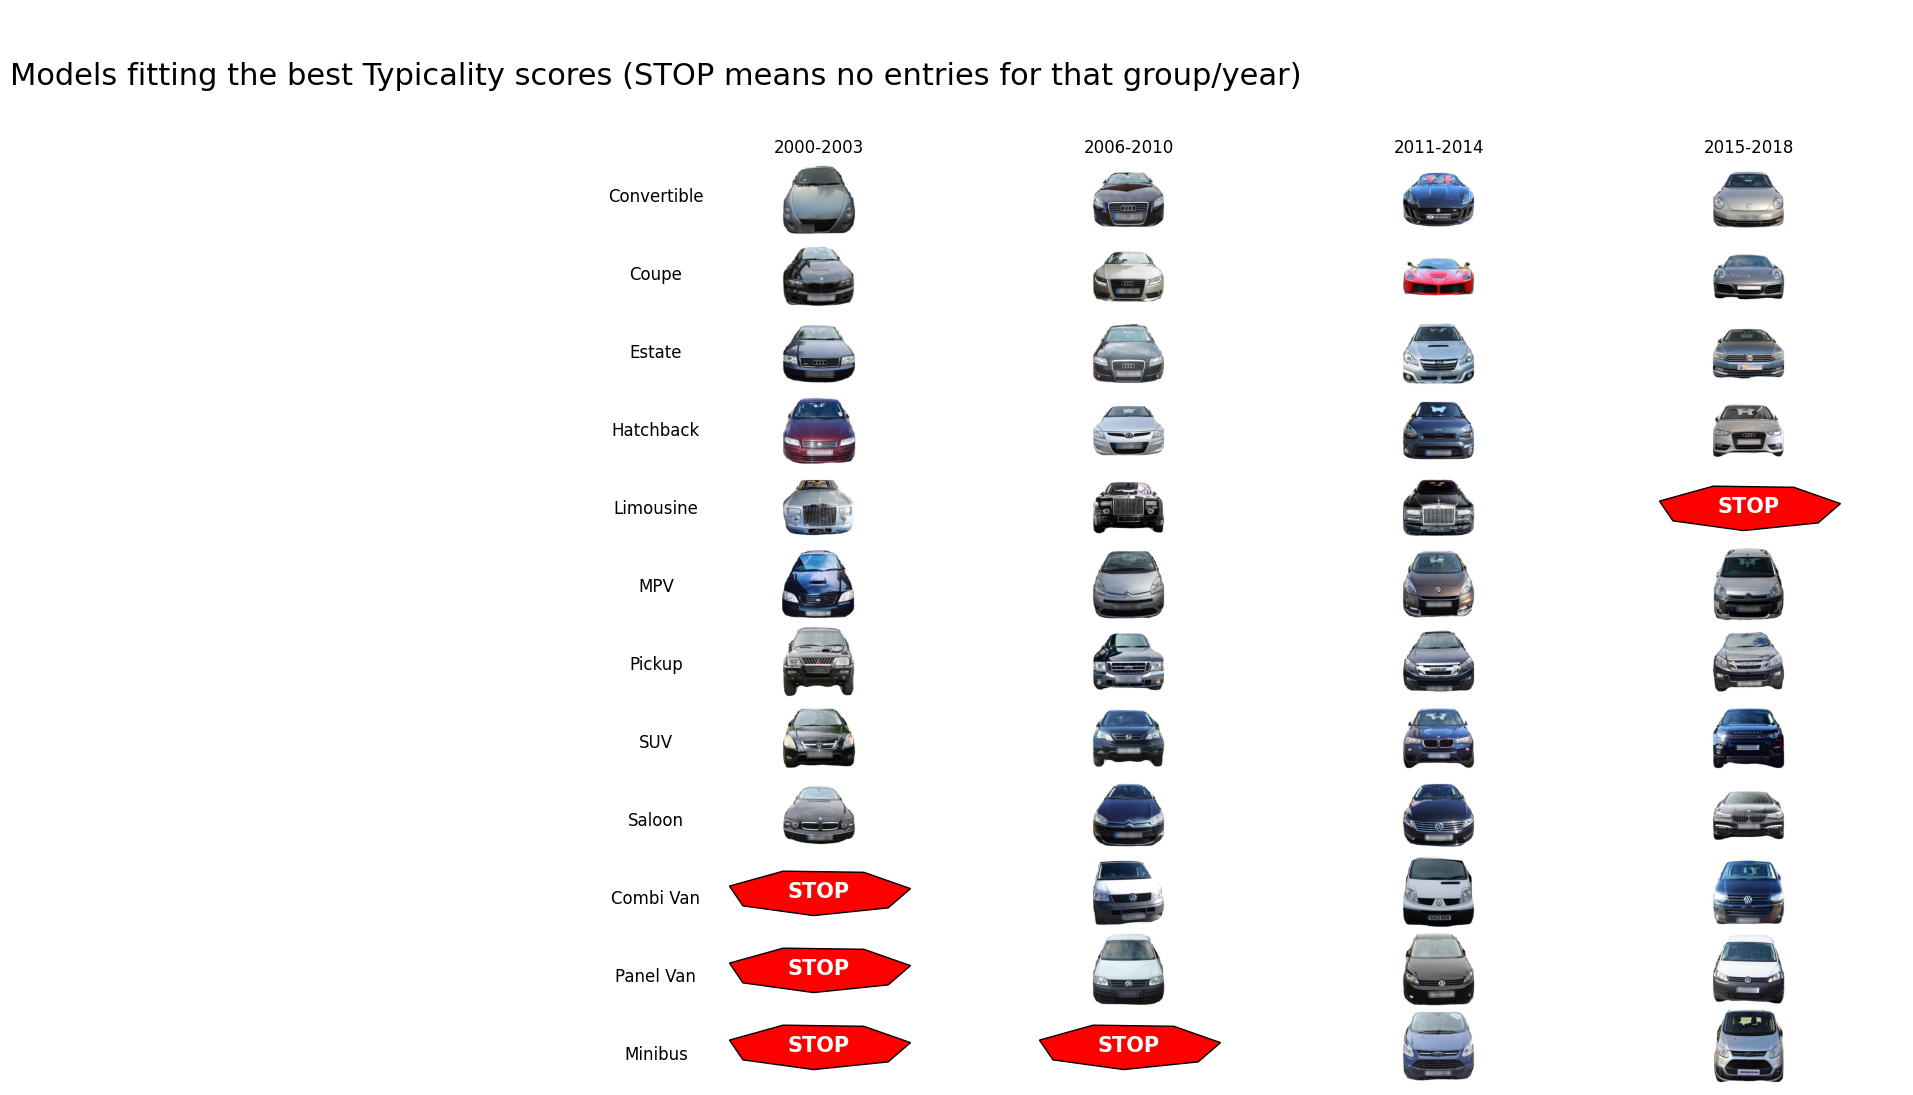

In [70]:
highest = pd.read_csv('highest.csv')

unique_bodytypes = highest['bodytype'].unique()
unique_years = highest['grouped_year'].unique()

fig, axes = plt.subplots(len(unique_bodytypes), len(unique_years), figsize=(16, 12))
fig.text(0.12, 1, '  ' , va='center', ha='center', rotation='horizontal', fontsize=10)
fig.text(0.12, 0.95, 'Models fitting the best Typicality scores (STOP means no entries for that group/year)' , va='center', ha='center', rotation='horizontal', fontsize=22)

for i, bodytype in enumerate(unique_bodytypes):
    for j, year in enumerate(unique_years):
        single = highest[(highest['bodytype'] == bodytype) & (highest['grouped_year'] == year)]
        if not single.empty:
            img = plt.imread(os.path.join(dir, single['File_Name'].values[0]))
            axes[i, j].imshow(img)
            if i == 0: 
                if j==0:
                    axes[i, j].set_title('2000-2003')      
                elif j==1: 
                        axes[i, j].set_title('2006-2010')
                elif j==2: 
                        axes[i, j].set_title('2011-2014') 
                elif j==3: 
                        axes[i, j].set_title('2015-2018')  
            axes[i, j].axis('off') 
            
        else:
            stop = patches.RegularPolygon((0.5, 0.5), numVertices=7, 
                                          radius=0.3, orientation=np.pi / 8, 
                                          edgecolor='black', facecolor='red', 
                                          transform=axes[i, j].transAxes)
            axes[i, j].add_patch(stop)
            axes[i, j].text(0.5, 0.5, 'STOP', 
                            horizontalalignment='center', 
                            verticalalignment='center',
                            transform=axes[i, j].transAxes, 
                            fontsize=15, color='white', 
                            fontweight='bold')
        
            axes[i, j].axis('off') 
    fig.text(0.12, 0.85 - i * (0.78 / len(unique_bodytypes)), bodytype, va='center', ha='center', rotation='horizontal', fontsize=12)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


## 6.  groups of cars selected
#### here I iterate through my previously generated grouped dfs and select a couple of them with their respective typicality scores

In [71]:
last_df = pd.DataFrame()  
counter = 0

for key, df in all_dfs.items():
    if counter == 2 or counter == 3 or counter == 5 or counter == 8 or counter == 10 or counter == 12 or counter == 16: 
        continue
    counter = counter + 1
    transformed = transformer3(dir, df, 0, encoder, var) # transform
    transformed_set = dataset(transformed['images'], transformed['labels']) # dataset
    transformed_loader = DataLoader(transformed_set, batch_size=64, shuffle=False, num_workers=0) # dataloader
    max_cos, max_ind, min_cos, min_ind, med_cos, med_ind = get_typicality(transformed_loader) # calculate cosine/design typicality
    if not med_ind == 0:
        highest = df.iloc[max_ind]
        lowest = df.iloc[min_ind]
        median = df.iloc[med_ind]
        highest['score'] = 2
        lowest['score'] = 0
        median['score'] = 1
        highest['group'] = key
        lowest['group'] = key
        median['group'] = key
        last_df = pd.concat([last_df, highest.to_frame().T, lowest.to_frame().T, median.to_frame().T], ignore_index=True)
    if counter == 5:
        break

last_df.to_csv('last.csv', index=False)
last_df.head(1)

,File_Name,Brand_Name,Model_Name,Launch_Year,Color,Model_ID,Advertiser_ID,Image_ID,grouped_year,bodytype,score,group
0,Daihatsu$$Copen$$2003$$Silver$$24_3$$7$$image_...,Daihatsu,Copen,2003,Silver,24_3,7,image_1.jpg,0,Convertible,2,0_Convertible


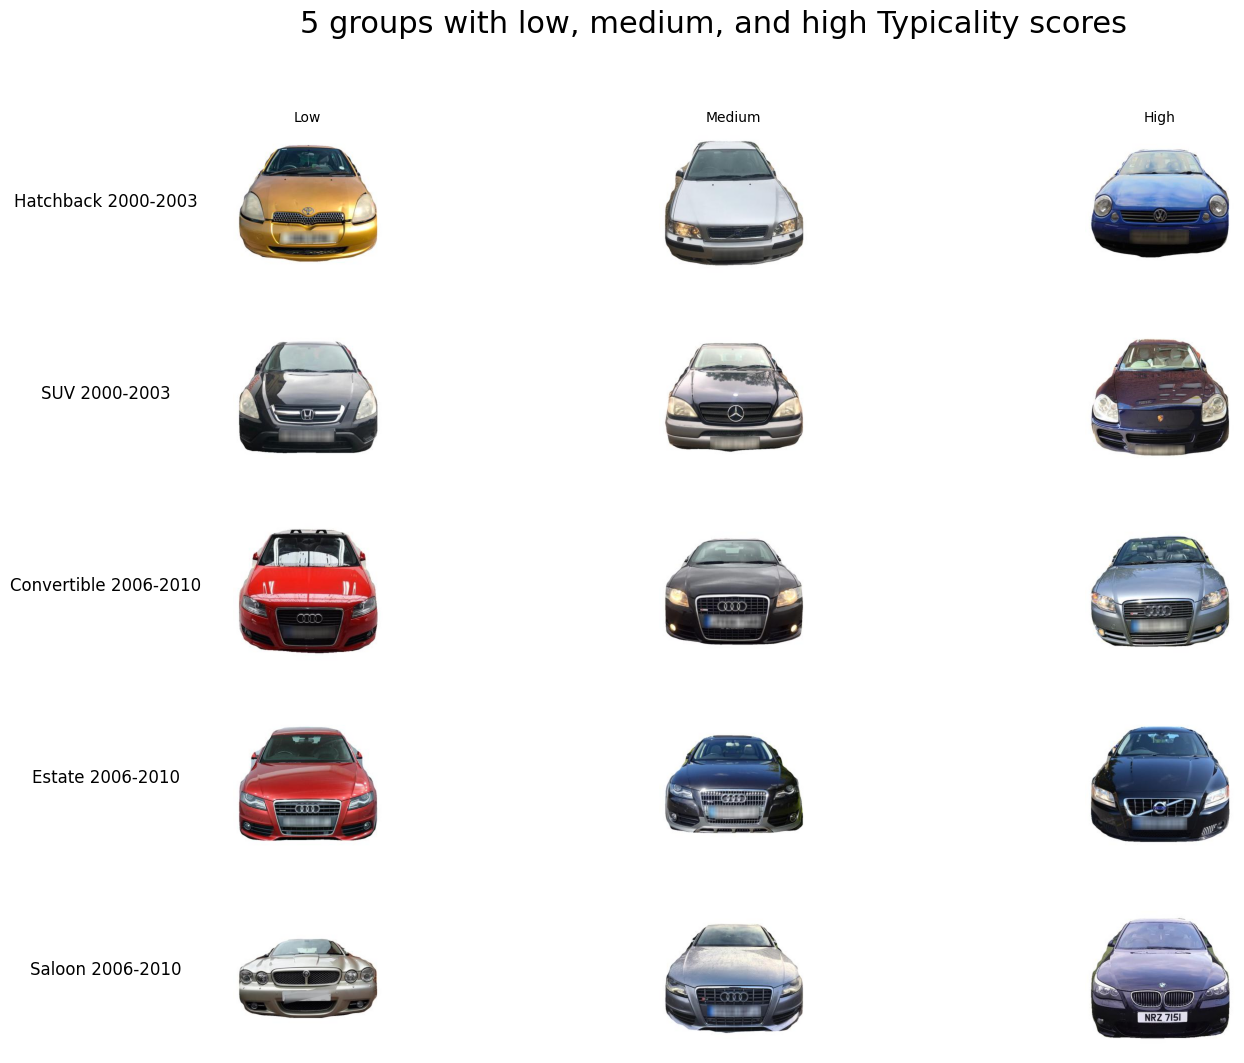

In [68]:
last = pd.read_csv('last.csv')

unique_scores = last['score'].unique()
unique_groupss = last['group'].unique()
unique_groups = unique_groupss[:5] # limit to 5
last['years'] = last['grouped_year'].map({0: '2000-2003', 1: '2006-2010', 2: '2011-2014', 3: '2015-2018'}) 
# add the names for the images

fig, axes = plt.subplots(len(unique_groups), 3, figsize=(16, 12))
fig.suptitle('5 groups with low, medium, and high Typicality scores', fontsize=22)

# plot all the images of cars
for i, group in enumerate(unique_groups):
    low = last[(last['group'] == group) & (last['score'] == 0)]
    med = last[(last['group'] == group) & (last['score'] == 1)]
    high = last[(last['group'] == group) & (last['score'] == 2)]
    axes[i, 0].imshow(plt.imread(os.path.join(dir, low['File_Name'].values[0])))
    axes[i, 1].imshow(plt.imread(os.path.join(dir, med['File_Name'].values[0])))
    axes[i, 2].imshow(plt.imread(os.path.join(dir, high['File_Name'].values[0])))
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 2].axis('off')
    if i==0:
            axes[i, 0].set_title('Low', fontsize=10)
            axes[i, 1].set_title('Medium', fontsize=10)
            axes[i, 2].set_title('High', fontsize=10)
    
    years = low['years'].item()
    bodytype = low['bodytype'].item()
    
    fig.text(0.12, 0.82 - i * (0.8 / len(unique_groups)), bodytype + ' ' + years, va='center', ha='center', rotation='horizontal', fontsize=12)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()